In [1]:
!pip install hdbscan
!pip install sentence-transformers
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 35.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039295 sha256=ef4b34c99b2e3b8a7deaeadabd1628bd11e4e70373ecd5343bfcf16082d3be68
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.9
    Uninstalling Cython-3.0.9:
      Successfully uninstalled Cython-3.0.9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

from hdbscan import HDBSCAN
from sklearn import metrics


from sentence_transformers import SentenceTransformer
import umap

In [17]:
import warnings
warnings.filterwarnings("ignore")

import os

In [18]:
from transformers import BertTokenizer, BertModel

In [19]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train_test = pd.concat([train, test], ignore_index=True)

In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [21]:
def get_sentence_embeddings(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    return embeddings

# Apply the function to each utterance
test['BERT_embeddings'] = test['text'].apply(get_sentence_embeddings)
test

,text,category,BERT_embeddings
0,How do I locate my card?,card_arrival,"[0.11946714, 0.0462514, 0.07216076, -0.0717430..."
1,"I still have not received my new card, I order...",card_arrival,"[0.1455653, -0.17301682, 0.396418, 0.20625193,..."
2,I ordered a card but it has not arrived. Help ...,card_arrival,"[-0.050330862, -0.2557014, 0.44595417, -0.0304..."
3,Is there a way to know when my card will arrive?,card_arrival,"[-0.044740878, -0.3670077, 0.41925043, 0.03467..."
4,My card has not arrived yet.,card_arrival,"[0.3028919, -0.22428086, 0.10192727, -0.203572..."
...,...,...,...
3075,"If i'm not in the UK, can I still get a card?",country_support,"[0.49874625, -0.046890993, 0.43037665, -0.3773..."
3076,How many countries do you support?,country_support,"[0.4169197, -0.19576609, 0.10278029, -0.101284..."
3077,What countries do you do business in?,country_support,"[0.43335438, -0.14970121, -0.07299802, -0.2744..."
3078,What are the countries you operate in.,country_support,"[0.26136342, -0.20304756, -0.15264143, -0.1744..."


In [22]:
bert_embeddings = np.vstack(test['BERT_embeddings'].to_numpy())

umap_embeddings = umap.UMAP(n_neighbors=10, n_components=5, metric='cosine').fit_transform(bert_embeddings)

In [23]:
hdbscan = HDBSCAN(min_cluster_size=18)
test["topic"] = hdbscan.fit_predict(umap_embeddings)
test

,text,category,BERT_embeddings,topic
0,How do I locate my card?,card_arrival,"[0.11946714, 0.0462514, 0.07216076, -0.0717430...",11
1,"I still have not received my new card, I order...",card_arrival,"[0.1455653, -0.17301682, 0.396418, 0.20625193,...",-1
2,I ordered a card but it has not arrived. Help ...,card_arrival,"[-0.050330862, -0.2557014, 0.44595417, -0.0304...",-1
3,Is there a way to know when my card will arrive?,card_arrival,"[-0.044740878, -0.3670077, 0.41925043, 0.03467...",-1
4,My card has not arrived yet.,card_arrival,"[0.3028919, -0.22428086, 0.10192727, -0.203572...",-1
...,...,...,...,...
3075,"If i'm not in the UK, can I still get a card?",country_support,"[0.49874625, -0.046890993, 0.43037665, -0.3773...",10
3076,How many countries do you support?,country_support,"[0.4169197, -0.19576609, 0.10278029, -0.101284...",11
3077,What countries do you do business in?,country_support,"[0.43335438, -0.14970121, -0.07299802, -0.2744...",11
3078,What are the countries you operate in.,country_support,"[0.26136342, -0.20304756, -0.15264143, -0.1744...",-1


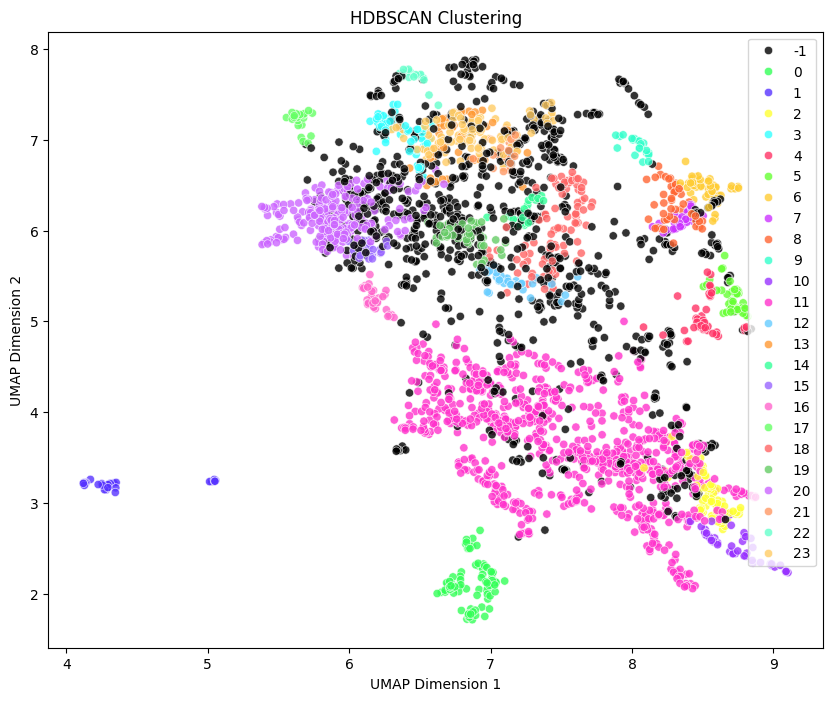

In [24]:
custom_colors = [
    '#000000', '#33FF57', '#5733FF', '#FFFF33', '#33FFFF',
    '#FF3366', '#66FF33', '#FFCC33', '#CC33FF',
    '#FF6633', '#33FFCC', '#9933FF', '#FF33CC', '#66CCFF',
    '#FF9933', '#33FF99', '#9966FF', '#FF66CC', '#66FF66',
    '#FF6666', '#66CC66', '#CC66FF', '#FF9966', '#66FFCC', '#FFCC66'
]
custom_palette = sns.color_palette(custom_colors)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=test["topic"], legend='full', alpha=0.8, palette=custom_palette)
plt.title('HDBSCAN Clustering')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()

In [25]:
cluster_info = {}
for i in np.unique(hdbscan.labels_):
  rah = test[test["topic"]== i]
  value_counts = rah["category"].value_counts()

  category_info = {}
  for index, count in value_counts.items():
    category_info[index] = count

  cluster_info[i] = category_info

cluster_info

{-1: {'lost_or_stolen_phone': 33,
  'request_refund': 29,
  'card_arrival': 28,
  'beneficiary_not_allowed': 25,
  'declined_card_payment': 24,
  'lost_or_stolen_card': 23,
  'card_swallowed': 22,
  'activate_my_card': 21,
  'card_payment_not_recognised': 21,
  'card_delivery_estimate': 20,
  'declined_cash_withdrawal': 20,
  'wrong_amount_of_cash_received': 20,
  'Refund_not_showing_up': 19,
  'why_verify_identity': 18,
  'cash_withdrawal_not_recognised': 18,
  'contactless_not_working': 18,
  'topping_up_by_card': 18,
  'declined_transfer': 17,
  'transaction_charged_twice': 17,
  'cancel_transfer': 17,
  'reverted_card_payment?': 16,
  'transfer_not_received_by_recipient': 16,
  'transfer_into_account': 15,
  'card_not_working': 15,
  'top_up_failed': 15,
  'pending_card_payment': 15,
  'extra_charge_on_statement': 15,
  'top_up_reverted': 14,
  'passcode_forgotten': 14,
  'failed_transfer': 12,
  'balance_not_updated_after_bank_transfer': 12,
  'verify_my_identity': 12,
  'direct_d

In [26]:
tokenizer = BertTokenizer.from_pretrained('philschmid/BERT-Banking77')
model = BertModel.from_pretrained('philschmid/BERT-Banking77')

tokenizer_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/5.95k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [27]:
def get_sentence_embeddings(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    return embeddings

# Apply the function to each utterance
test['BERT77_embeddings'] = test['text'].apply(get_sentence_embeddings)
test

,text,category,BERT_embeddings,topic,BERT77_embeddings
0,How do I locate my card?,card_arrival,"[0.11946714, 0.0462514, 0.07216076, -0.0717430...",11,"[0.42865202, -0.43469578, 0.3052942, 0.2347375..."
1,"I still have not received my new card, I order...",card_arrival,"[0.1455653, -0.17301682, 0.396418, 0.20625193,...",-1,"[0.16829188, 0.09822858, 1.3819345, -0.1845505..."
2,I ordered a card but it has not arrived. Help ...,card_arrival,"[-0.050330862, -0.2557014, 0.44595417, -0.0304...",-1,"[0.12018974, -0.12311054, 1.4518343, 0.2730053..."
3,Is there a way to know when my card will arrive?,card_arrival,"[-0.044740878, -0.3670077, 0.41925043, 0.03467...",-1,"[-0.15183571, 0.082956925, 1.4436911, 0.078706..."
4,My card has not arrived yet.,card_arrival,"[0.3028919, -0.22428086, 0.10192727, -0.203572...",-1,"[0.24080856, 0.40944988, 1.2567027, -0.2404651..."
...,...,...,...,...,...
3075,"If i'm not in the UK, can I still get a card?",country_support,"[0.49874625, -0.046890993, 0.43037665, -0.3773...",10,"[0.27429864, -0.82551634, 0.25383866, 0.810523..."
3076,How many countries do you support?,country_support,"[0.4169197, -0.19576609, 0.10278029, -0.101284...",11,"[0.3326514, -0.5459342, 0.062237754, 0.7839224..."
3077,What countries do you do business in?,country_support,"[0.43335438, -0.14970121, -0.07299802, -0.2744...",11,"[0.4262836, -0.46747416, 0.20949411, 0.7919105..."
3078,What are the countries you operate in.,country_support,"[0.26136342, -0.20304756, -0.15264143, -0.1744...",-1,"[0.41575032, -0.5905341, 0.29422665, 0.8811767..."


In [28]:
bert77_embeddings = np.vstack(test['BERT77_embeddings'].to_numpy())

umap_embeddings_77 = umap.UMAP(n_neighbors=10, n_components=5, metric='cosine').fit_transform(bert77_embeddings)

In [29]:
hdbscan = HDBSCAN(min_cluster_size=18)
test["topic77"] = hdbscan.fit_predict(umap_embeddings_77)
test

,text,category,BERT_embeddings,topic,BERT77_embeddings,topic77
0,How do I locate my card?,card_arrival,"[0.11946714, 0.0462514, 0.07216076, -0.0717430...",11,"[0.42865202, -0.43469578, 0.3052942, 0.2347375...",49
1,"I still have not received my new card, I order...",card_arrival,"[0.1455653, -0.17301682, 0.396418, 0.20625193,...",-1,"[0.16829188, 0.09822858, 1.3819345, -0.1845505...",48
2,I ordered a card but it has not arrived. Help ...,card_arrival,"[-0.050330862, -0.2557014, 0.44595417, -0.0304...",-1,"[0.12018974, -0.12311054, 1.4518343, 0.2730053...",48
3,Is there a way to know when my card will arrive?,card_arrival,"[-0.044740878, -0.3670077, 0.41925043, 0.03467...",-1,"[-0.15183571, 0.082956925, 1.4436911, 0.078706...",1
4,My card has not arrived yet.,card_arrival,"[0.3028919, -0.22428086, 0.10192727, -0.203572...",-1,"[0.24080856, 0.40944988, 1.2567027, -0.2404651...",48
...,...,...,...,...,...,...
3075,"If i'm not in the UK, can I still get a card?",country_support,"[0.49874625, -0.046890993, 0.43037665, -0.3773...",10,"[0.27429864, -0.82551634, 0.25383866, 0.810523...",67
3076,How many countries do you support?,country_support,"[0.4169197, -0.19576609, 0.10278029, -0.101284...",11,"[0.3326514, -0.5459342, 0.062237754, 0.7839224...",67
3077,What countries do you do business in?,country_support,"[0.43335438, -0.14970121, -0.07299802, -0.2744...",11,"[0.4262836, -0.46747416, 0.20949411, 0.7919105...",67
3078,What are the countries you operate in.,country_support,"[0.26136342, -0.20304756, -0.15264143, -0.1744...",-1,"[0.41575032, -0.5905341, 0.29422665, 0.8811767...",67


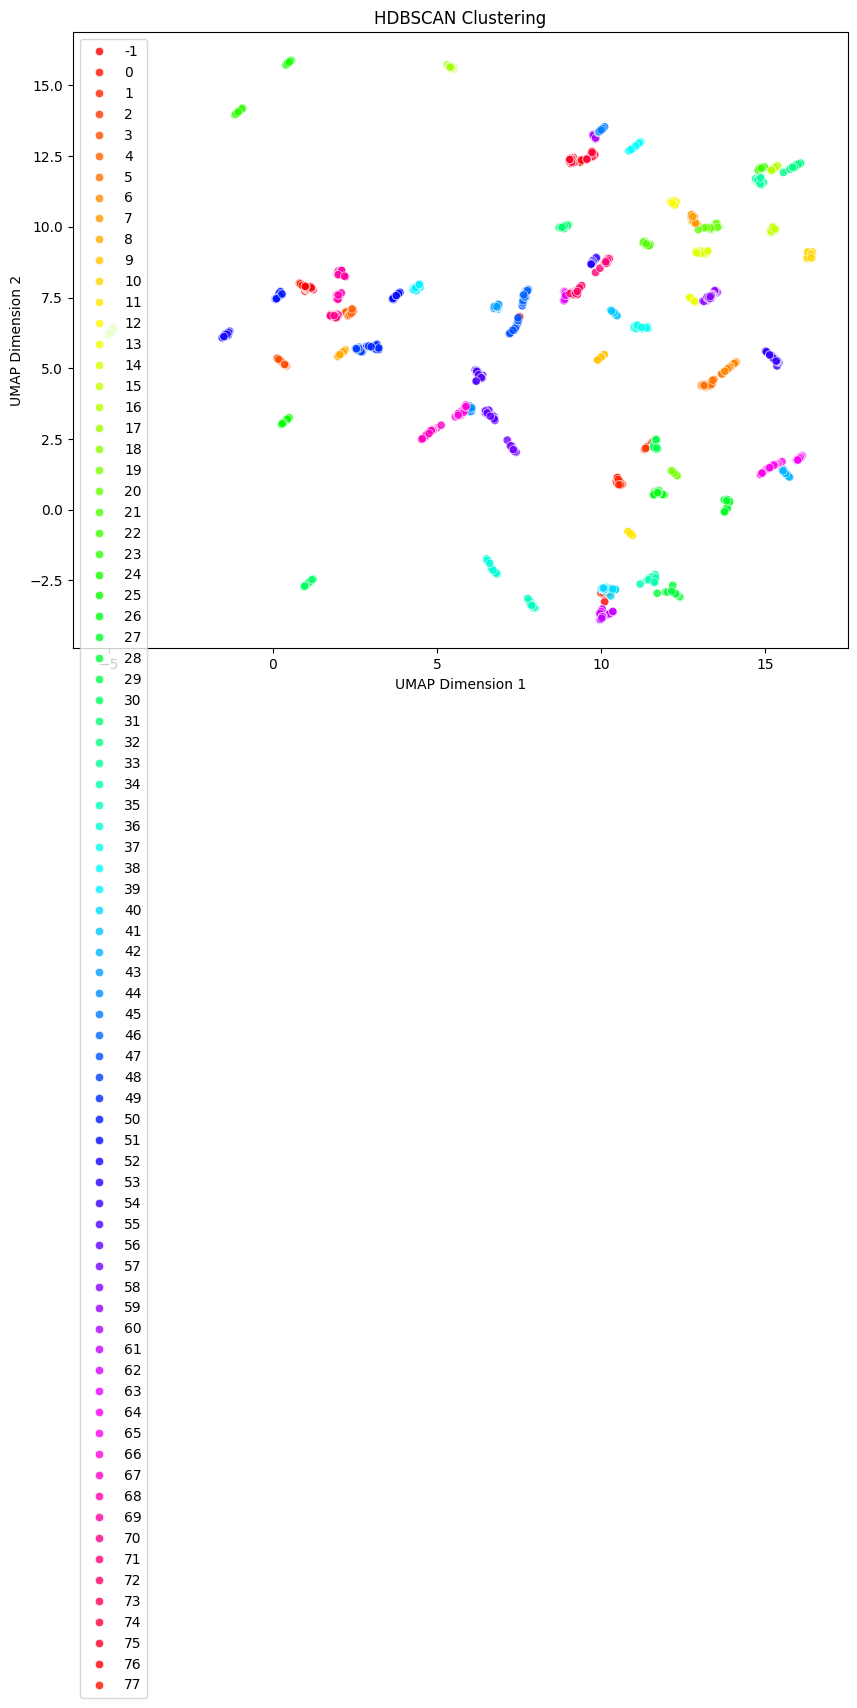

In [48]:
hues = np.linspace(0, 1, 77, endpoint=False)
saturation = 0.9
value = 0.9

custom_palette = [plt.cm.hsv(h) for h in hues]

plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_embeddings_77[:, 0], y=umap_embeddings_77[:, 1], hue=test["topic77"], legend='full', alpha=0.8, palette=custom_palette)
plt.title('HDBSCAN Clustering')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()

In [32]:
cluster_info_77 = {}
for i in np.unique(hdbscan.labels_):
  rah = test[test["topic77"]== i]
  value_counts = rah["category"].value_counts()

  category_info = {}
  for index, count in value_counts.items():
    category_info[index] = count

  cluster_info[i] = category_info

cluster_info

{-1: {'compromised_card': 3,
  'why_verify_identity': 2,
  'get_disposable_virtual_card': 2,
  'automatic_top_up': 1,
  'top_up_reverted': 1,
  'card_payment_not_recognised': 1,
  'disposable_card_limits': 1,
  'getting_spare_card': 1,
  'virtual_card_not_working': 1},
 0: {'pending_card_payment': 37,
  'fiat_currency_support': 1,
  'pending_transfer': 1},
 1: {'card_delivery_estimate': 35,
  'card_arrival': 4,
  'pending_card_payment': 1},
 2: {'receiving_money': 38, 'exchange_via_app': 1, 'declined_transfer': 1},
 3: {'verify_top_up': 40},
 4: {'age_limit': 40},
 5: {'exchange_via_app': 38,
  'fiat_currency_support': 3,
  'exchange_rate': 1,
  'exchange_charge': 1},
 6: {'fiat_currency_support': 35,
  'supported_cards_and_currencies': 2,
  'card_delivery_estimate': 1,
  'exchange_via_app': 1,
  'receiving_money': 1},
 7: {'exchange_rate': 39,
  'exchange_charge': 2,
  'card_payment_wrong_exchange_rate': 1,
  'wrong_exchange_rate_for_cash_withdrawal': 1},
 8: {'edit_personal_details':